In [5]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.optim as optim
import cellpylib as cpl
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import sys
from matplotlib import pyplot as plt

In [6]:
sys.path.append("C:/Users/windows/Research/CA_Project")
from block_entropy import get_block_entropy_feature_matrix, get_block_entropy_feature_vector, block_entropy, mutual_information_feature_vector

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Data Generation

In [ ]:
def generate_1D_feature_maps(num_samples, rule_number, ca_size, window_size, L):
    
    # Initialize dataset array
    input_data = np.zeros((num_samples, 2, ca_size))  
    output_data = np.zeros((num_samples, 1, ca_size))
    
    ics = np.zeros((num_samples, ca_size))
    for n in range(num_samples):
        duplicate = True
        while duplicate:
            ic = cpl.init_random(size=ca_size)
            if np.array_equal(ics, ic[0]) == False:
                duplicate = False
                state = cpl.evolve(ic, timesteps=2, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number), memoize=True)[1]
                prev_state = ic[0]
        
        
        # get entropy feature map
        H = get_block_entropy_feature_vector(state, window_size, L)
        
        # get mutual information feature map
        I = mutual_information_feature_vector(state, prev_state, window_size)
    
        
        input_data[n][0] = H
        input_data[n][1] = I
    
        output_data[n][0] = ic[0]
        
    input_data = torch.from_numpy(input_data).to(torch.float32)
    output_data = torch.from_numpy(output_data).to(torch.float32)
        
    return input_data, output_data

In [8]:
def generate_1D_spacetime_feature_maps(num_samples, rule_number, ca_size, H_window_size, I_window_size, L):
    
    # Initialize dataset array
    input_data = np.zeros((num_samples, 2, ca_size, ca_size))  
    output_data = np.zeros((num_samples, 1, ca_size, ca_size))
    
    ics = np.zeros((num_samples, ca_size, ca_size))
    for n in range(num_samples):
        
        print(f"generating sample {n}...")
        
        ic = cpl.init_random(ca_size)
        
        spacetime = cpl.evolve(ic, timesteps=ca_size+1, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number), memoize=True)
        for t in range(ca_size):
            
            state = spacetime[t+1]
            prev_state = spacetime[t]

            # get entropy feature map
            H = get_block_entropy_feature_vector(state, H_window_size, L)

            # get mutual information feature map
            I = mutual_information_feature_vector(state, prev_state, I_window_size)
    
        
            input_data[n][0][t] = H
            input_data[n][1][t] = I

        output_data[n][0] = spacetime[1:]
             
    input_data = torch.from_numpy(input_data).to(torch.float32)
    output_data = torch.from_numpy(output_data).to(torch.float32)
        
    return input_data, output_data

In [9]:
x_data = torch.load('C:\\Users\\windows\\Research\\CA_Project\\datasets\\spacetime_features_to_state_input_data.pt')
y_data = torch.load('C:\\Users\\windows\\Research\\CA_Project\\datasets\\spacetime_features_to_state_output_data.pt')

print("x_data", x_data.size())
print("y_data", y_data.size())

x_data torch.Size([6000, 2, 128, 128])
y_data torch.Size([6000, 1, 128, 128])


## Split Data Into Training Set and Validation Set

In [10]:
split = int(0.85 * len(x_data))
print(split)
x_train = x_data[:split]
y_train = y_data[:split]
x_val = x_data[split:]
y_val = y_data[split:]

5100


In [11]:
batch_size = 32

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## Build Neural Network

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=24, kernel_size=(5, 5), padding=2)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=12, kernel_size=(5, 5), padding=2)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(5, 5), padding=2)
        self.conv_final = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=(1, 1))
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x
        
        # if I want to convert to binary numbers, then I can just do torch.round()
        # However, I should note that doing that here will destroy the gradient

model2 = ConvNet().to(device)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

print(model2)

ConvNet(
  (conv1): Conv2d(2, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(24, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv_final): Conv2d(12, 1, kernel_size=(1, 1), stride=(1, 1))
)


## Optimization Loop

In [16]:
n_epochs = 300
accuracies = np.zeros(n_epochs)

for epoch in range(n_epochs):
    
    print("\n-------------------------------")
    
    # train loop
    model2.train()
    for batch, (inputs, outputs) in enumerate(train_loader):
        
        inputs, outputs = inputs.to(device), outputs.to(device)
        
        # compute predictions
        predictions = model2(inputs)
        
        # calculate loss
        loss = loss_fn(predictions, outputs)
        
        #backpropogation
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # print progress
        # if (batch+1) % 10 == 0:
            # print(f'Epoch [{epoch+1}/{n_epochs}], Step [{batch+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # writer.add_scalar("Training Loss", loss, global_step=step)
        # step += 1
        
            
    # validation loop
    model2.eval()
    
    val_loss, correct = 0, 0
    
    with torch.no_grad():
        
        for inputs, outputs in val_loader:
            
            inputs, outputs = inputs.to(device), outputs.to(device)
            
            predictions = model2(inputs)
            loss = loss_fn(predictions, outputs)
            val_loss += loss.item()
                
            # correct += (torch.round(predictions) == outputs).sum().item()
            for i in range(len(predictions)):
                rounded_prediction = torch.round(predictions[i])
                if rounded_prediction.equal(outputs[i]):
                    correct += 1
            
    average_val_loss = val_loss / len(val_loader)
    total = len(val_loader.dataset)
    accuracy = correct / total
    accuracies[epoch] = accuracy
    
    print(f'Epoch [{epoch+1}/{n_epochs}], Validation Loss: {average_val_loss:.4f}, Test Accuracy: {accuracy:.2%}')
    print('correct:', correct)
    print('total:', total)
    

    
print('Training and Testing finished.')
    


-------------------------------
Epoch [1/300], Validation Loss: 0.0081, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [2/300], Validation Loss: 0.0062, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [3/300], Validation Loss: 0.0049, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [4/300], Validation Loss: 0.0041, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [5/300], Validation Loss: 0.0035, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [6/300], Validation Loss: 0.0030, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [7/300], Validation Loss: 0.0026, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [8/300], Validation Loss: 0.0023, Test Accuracy: 0.00%
correct: 0
total: 900

-------------------------------
Epoch [9/300], Validation Loss: 0.0020,

Epoch [70/300], Validation Loss: 0.0000, Test Accuracy: 86.78%
correct: 781
total: 900

-------------------------------
Epoch [71/300], Validation Loss: 0.0000, Test Accuracy: 88.89%
correct: 800
total: 900

-------------------------------
Epoch [72/300], Validation Loss: 0.0000, Test Accuracy: 87.67%
correct: 789
total: 900

-------------------------------
Epoch [73/300], Validation Loss: 0.0000, Test Accuracy: 88.00%
correct: 792
total: 900

-------------------------------
Epoch [74/300], Validation Loss: 0.0000, Test Accuracy: 89.33%
correct: 804
total: 900

-------------------------------
Epoch [75/300], Validation Loss: 0.0000, Test Accuracy: 88.22%
correct: 794
total: 900

-------------------------------
Epoch [76/300], Validation Loss: 0.0015, Test Accuracy: 0.22%
correct: 2
total: 900

-------------------------------
Epoch [77/300], Validation Loss: 0.0007, Test Accuracy: 2.22%
correct: 20
total: 900

-------------------------------
Epoch [78/300], Validation Loss: 0.0005, Test

Epoch [139/300], Validation Loss: 0.0000, Test Accuracy: 96.78%
correct: 871
total: 900

-------------------------------
Epoch [140/300], Validation Loss: 0.0000, Test Accuracy: 97.11%
correct: 874
total: 900

-------------------------------
Epoch [141/300], Validation Loss: 0.0000, Test Accuracy: 97.11%
correct: 874
total: 900

-------------------------------
Epoch [142/300], Validation Loss: 0.0000, Test Accuracy: 96.56%
correct: 869
total: 900

-------------------------------
Epoch [143/300], Validation Loss: 0.0000, Test Accuracy: 97.22%
correct: 875
total: 900

-------------------------------
Epoch [144/300], Validation Loss: 0.0000, Test Accuracy: 97.56%
correct: 878
total: 900

-------------------------------
Epoch [145/300], Validation Loss: 0.0000, Test Accuracy: 95.33%
correct: 858
total: 900

-------------------------------
Epoch [146/300], Validation Loss: 0.0000, Test Accuracy: 97.44%
correct: 877
total: 900

-------------------------------
Epoch [147/300], Validation Loss

Epoch [207/300], Validation Loss: 0.0000, Test Accuracy: 95.89%
correct: 863
total: 900

-------------------------------
Epoch [208/300], Validation Loss: 0.0000, Test Accuracy: 96.11%
correct: 865
total: 900

-------------------------------
Epoch [209/300], Validation Loss: 0.0000, Test Accuracy: 96.00%
correct: 864
total: 900

-------------------------------
Epoch [210/300], Validation Loss: 0.0000, Test Accuracy: 95.78%
correct: 862
total: 900

-------------------------------
Epoch [211/300], Validation Loss: 0.0000, Test Accuracy: 95.11%
correct: 856
total: 900

-------------------------------
Epoch [212/300], Validation Loss: 0.0000, Test Accuracy: 95.78%
correct: 862
total: 900

-------------------------------
Epoch [213/300], Validation Loss: 0.0000, Test Accuracy: 96.44%
correct: 868
total: 900

-------------------------------
Epoch [214/300], Validation Loss: 0.0000, Test Accuracy: 96.11%
correct: 865
total: 900

-------------------------------
Epoch [215/300], Validation Loss

Epoch [275/300], Validation Loss: 0.0000, Test Accuracy: 99.44%
correct: 895
total: 900

-------------------------------
Epoch [276/300], Validation Loss: 0.0000, Test Accuracy: 99.33%
correct: 894
total: 900

-------------------------------
Epoch [277/300], Validation Loss: 0.0000, Test Accuracy: 99.22%
correct: 893
total: 900

-------------------------------
Epoch [278/300], Validation Loss: 0.0000, Test Accuracy: 99.33%
correct: 894
total: 900

-------------------------------
Epoch [279/300], Validation Loss: 0.0000, Test Accuracy: 99.33%
correct: 894
total: 900

-------------------------------
Epoch [280/300], Validation Loss: 0.0000, Test Accuracy: 99.33%
correct: 894
total: 900

-------------------------------
Epoch [281/300], Validation Loss: 0.0000, Test Accuracy: 99.44%
correct: 895
total: 900

-------------------------------
Epoch [282/300], Validation Loss: 0.0000, Test Accuracy: 99.44%
correct: 895
total: 900

-------------------------------
Epoch [283/300], Validation Loss

In [19]:
checkpoint = {
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': n_epochs,
    'accuracies': accuracies
    
}

# Specify the file path where you want to save the model
save_path = 'C:\\Users\\windows\\Research\\CA_Project\\pytorch_stuff\\models\\Features_to_Spacetime_Trained_Model.pth'

# Save the checkpoint
torch.save(checkpoint, save_path)

In [91]:
maps, state = generate_1D_spacetime_feature_maps(num_samples=1, rule_number=225, ca_size=128, H_window_size=9, I_window_size=9, L=1)
H = maps[0][0]
I = maps[0][1]

generating sample 0...


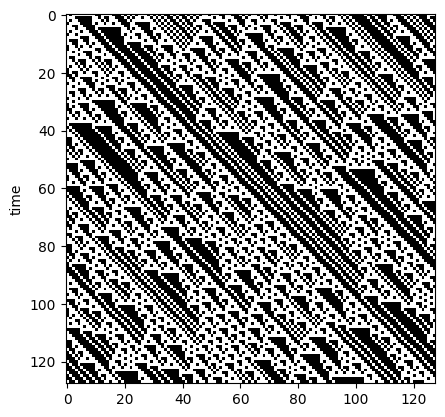

In [92]:
cpl.plot(state[0][0])

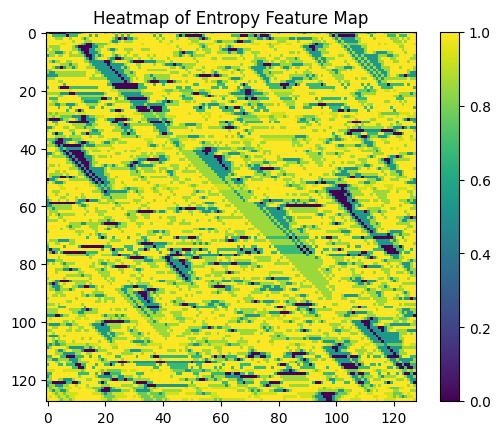

In [93]:
plt.imshow(H, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to indicate the values
plt.title("Heatmap of Entropy Feature Map")
plt.show()

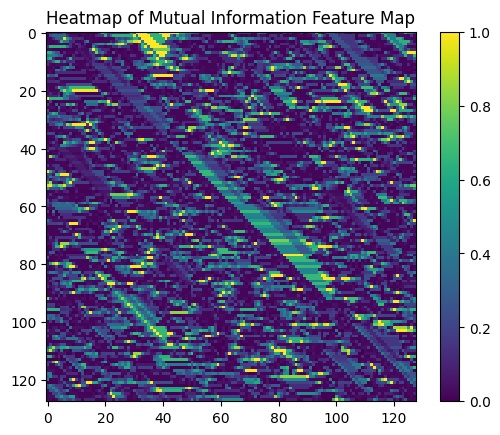

In [94]:
plt.imshow(I, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to indicate the values
plt.title("Heatmap of Mutual Information Feature Map")
plt.show()


In [52]:
x = maps[0].to(device)
prediction = torch.round(model2(x))
pred = prediction.detach()
pred = pred.cpu()
pred = pred.numpy()


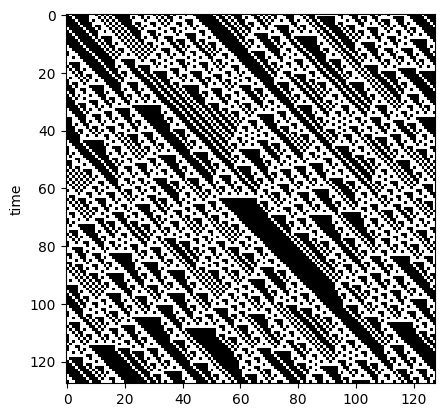

In [53]:
cpl.plot(pred[0])

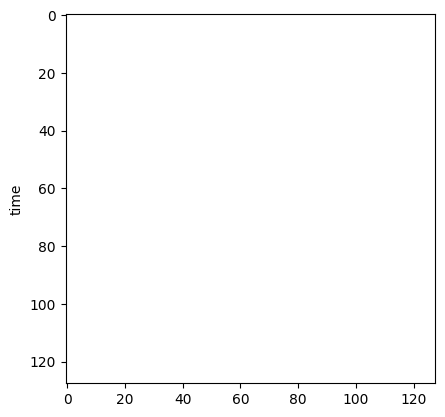

In [54]:
error = pred[0]-state[0][0].numpy()
cpl.plot(error)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='cuda:0')


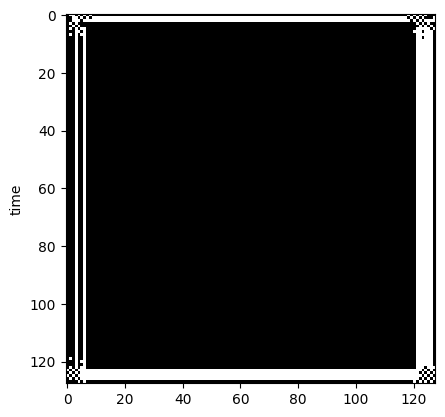

In [86]:
I = torch.ones((128, 128))
#I = I.new_full(size=(128, 128), fill_value=0.274)

H = torch.ones((128, 128))
# H = H.new_full(size=(128, 128), fill_value=0.7435)

maps = torch.zeros((1, 2, 128, 128)).to(device)
maps[0][1] = I
maps[0][0] = H

print(maps)

prediction = torch.round(model2(maps))
pred = prediction.detach()
pred = pred.cpu()
pred = pred.numpy()
cpl.plot(pred[0][0])